In [4]:
from utils import import_train_data
df, test_df = import_train_data()
df.sample(10)

,image_path,category,target,r
1341,data/알파벳인식/D/D/4d_al_D_41.jpg,alphabet,D,False
656,data/숫자인식/06/r_n06/4d_r_n06_06.jpg,number,6,True
2945,data/알파벳인식/T/T/4d_al_T_25.jpg,alphabet,T,False
3862,data/자유패턴/30/30_g/30_g05.jpg,free_pattern,None,None
3458,data/알파벳인식/Y/Y/4d_al_Y_38.jpg,alphabet,Y,False
2033,data/알파벳인식/K/K/4d_al_K_12.jpg,alphabet,K,False
2531,data/알파벳인식/P/P/4d_al_P_10.jpg,alphabet,P,False
1581,data/알파벳인식/F/r_F/4d_al_r_F_25.jpg,alphabet,F,True
1242,data/알파벳인식/C/C/4d_al_c_42.jpg,alphabet,C,False
2705,data/알파벳인식/Q/r_Q/4d_al_r_Q_35.jpg,alphabet,Q,True


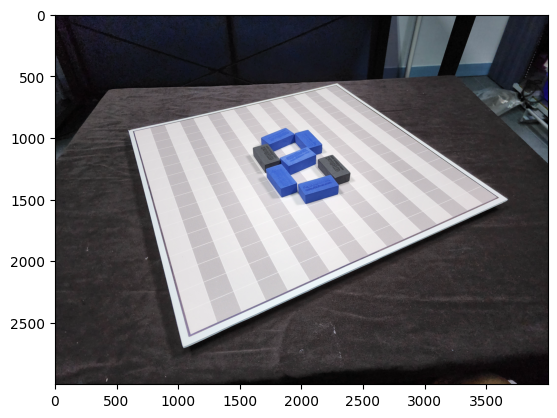

In [6]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

sample_img = cv2.imread(df['image_path'].sample(1).values[0])
plt.imshow(sample_img)

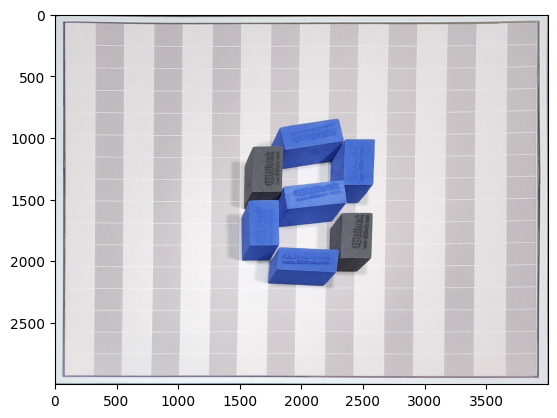

In [7]:
def sort_vertices(vertices, h, w):
    image_corners = np.array([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]], dtype=np.float32)
    corner_candidates = []
    for i in range(4):
        corner_candidates.append(np.roll(vertices, i, axis=0))

    displacements = []
    for corners in corner_candidates:
        corners = np.array(corners, dtype=np.float32)
        displacement = 0
        for corner, image_corner in zip(corners, image_corners):
            displacement += np.linalg.norm(corner - image_corner)
        displacements.append(displacement)

    min_displacement_index = np.argmin(displacements)

    best_corners = corner_candidates[min_displacement_index]

    return np.array(best_corners, dtype=np.float32)

def get_board_contour(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

def get_corners(contour):
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.05 * perimeter, True)
    return approx[:, 0, :]

def warp_image(img, origin_points, h, w):
    dest_points = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]])
    perspective_matrix = cv2.getPerspectiveTransform(origin_points, dest_points)
    transformed = cv2.warpPerspective(img, perspective_matrix, (w, h), flags=cv2.INTER_LINEAR)
    return transformed

def img_transform(img):
    contour = get_board_contour(img)
    corners = get_corners(contour)
    if len(corners) != 4:
        return img
    h, w, _ = img.shape
    origin_points = sort_vertices(corners, h, w)
    img = warp_image(img, origin_points, h, w)
    return img

plt.imshow(img_transform(sample_img))

now check a problematic image..

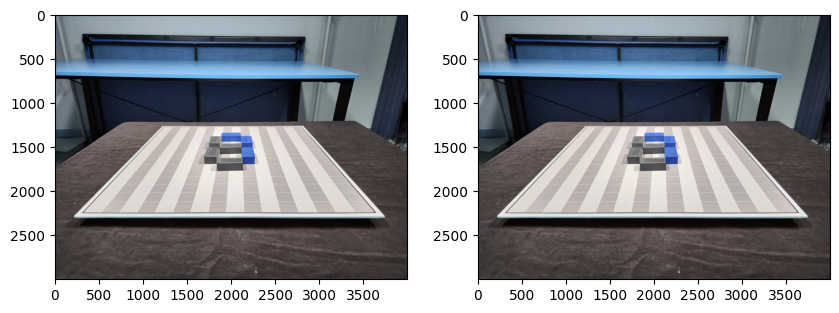

In [36]:
img = cv2.imread(df['image_path'].sample(1).values[0])
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img)
ax[1].imshow(img_transform(img))

Finally found one, now find a better way to choose the contour for warping

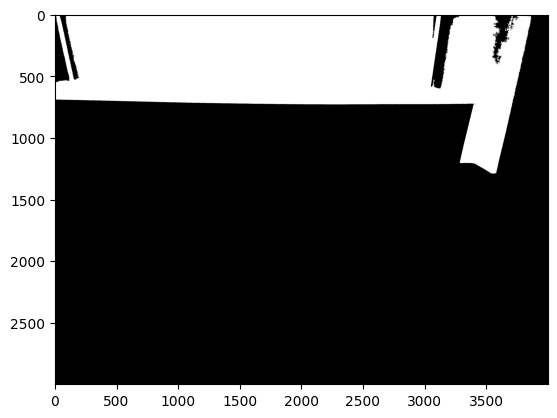

In [39]:
board_contour = get_board_contour(img)
contour_mask = np.zeros(img.shape[:2], dtype=np.uint8)
cv2.drawContours(contour_mask, [board_contour], -1, 255, -1)
plt.imshow(contour_mask, cmap='gray')

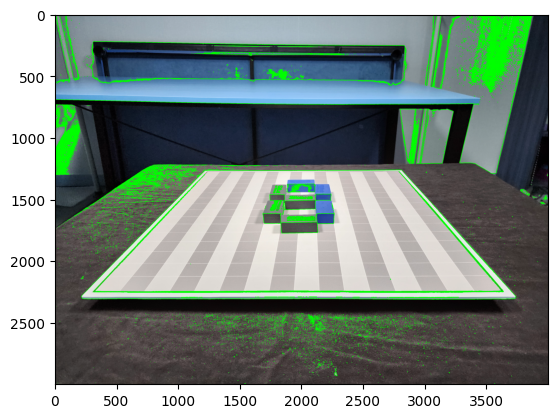

In [40]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contour_img = img.copy()
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 3)
plt.imshow(contour_img)

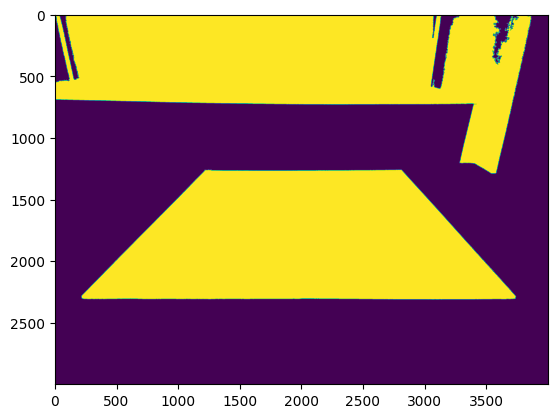

In [44]:
# find largest 2 contours
contour_areas = [cv2.contourArea(contour) for contour in contours]
largest_contour_indices = np.argsort(contour_areas)[-2:]
largest_contours = [contours[i] for i in largest_contour_indices]

contour_img = np.zeros(img.shape[:2], dtype=np.uint8)
cv2.drawContours(contour_img, largest_contours, -1, 255, -1)
plt.imshow(contour_img)

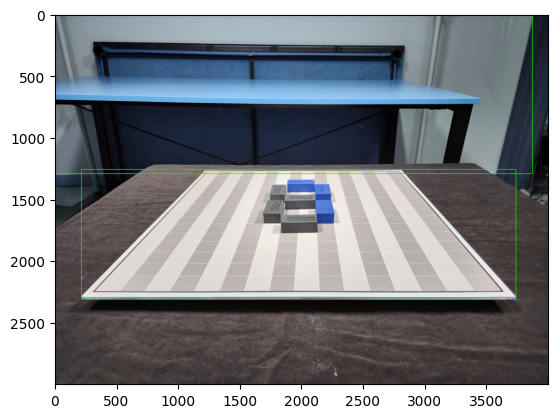

In [48]:
# visualize each contours boundingrect
contour_img = img.copy()
for contour in largest_contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(contour_img, (x, y), (x+w, y+h), (0, 255, 0), 3)
plt.imshow(contour_img)

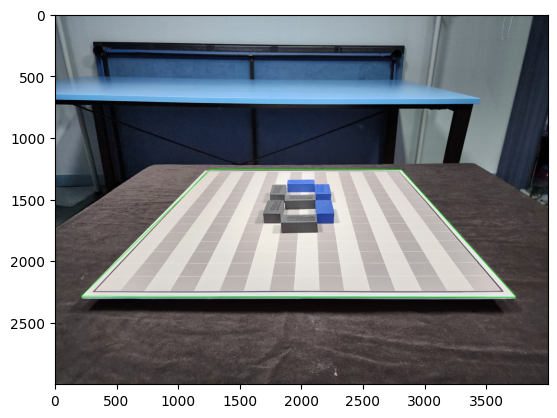

In [52]:
approx = cv2.approxPolyDP(largest_contours[0], 0.05 * cv2.arcLength(largest_contours[0], True), True)
approx = approx[:, 0, :]
approx

# visualize approximated polygon
contour_img = img.copy()
cv2.polylines(contour_img, [approx], True, (0, 255, 0), 3)
plt.imshow(contour_img)

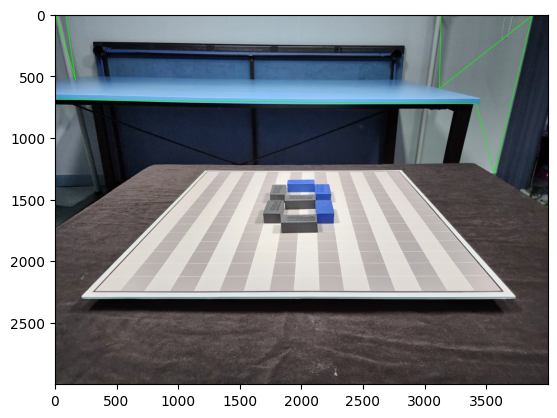

In [57]:
approx = cv2.approxPolyDP(largest_contours[1], 0.05 * cv2.arcLength(largest_contours[0], True), True)
approx = approx[:, 0, :]
approx

contour_img = img.copy()
cv2.polylines(contour_img, [approx], True, (0, 255, 0), 3)
plt.imshow(contour_img)

In [58]:
approx

array([[   0,  693],
       [3418,  728],
       [3563, 1293],
       [3872,   11],
       [3118,  604],
       [3132,    0],
       [  86,    0],
       [ 166,  533],
       [   7,    0]], dtype=int32)

In [72]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contour_areas = [cv2.contourArea(contour) for contour in contours]
largest_contour_indices = np.argsort(contour_areas)[-2:]
largest_contours = [contours[i] for i in largest_contour_indices]

for contour in largest_contours:
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.05 * perimeter, True)
    approx = approx[:, 0, :]
    if len(approx) == 4:
        print(approx)

[[ 214 2287]
 [3738 2294]
 [2810 1263]
 [1265 1259]]


In [99]:
def get_board_corners(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    contour_areas = [cv2.contourArea(contour) for contour in contours]
    largest_contour_indices = np.argsort(contour_areas)[-3:]
    largest_contours = [contours[i] for i in largest_contour_indices]
    largest_contours.sort(key=cv2.contourArea, reverse=True)
    for contour in largest_contours:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.05 * perimeter, True)
        approx = approx[:, 0, :]
        if len(approx) == 4:
            return approx
    return np.array([[0, 0], [0, img.shape[0]-1], [img.shape[1]-1, img.shape[0]-1], [img.shape[1]-1, 0]], dtype=np.float32)

In [78]:
get_board_corners(img)

array([[ 214, 2287],
       [3738, 2294],
       [2810, 1263],
       [1265, 1259]], dtype=int32)

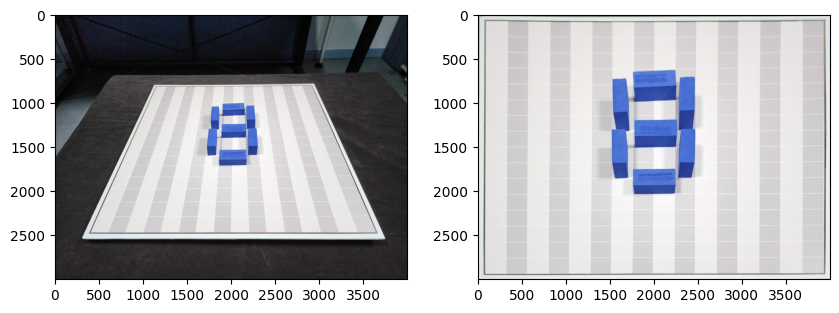

In [100]:
def warp_to_board(img):
    corners = get_board_corners(img)
    h, w, _ = img.shape
    origin_points = sort_vertices(corners, h, w)
    warped_image = warp_image(img, origin_points, h, w)
    return warped_image
warped_img = warp_to_board(img)
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img)
ax[1].imshow(warped_img)

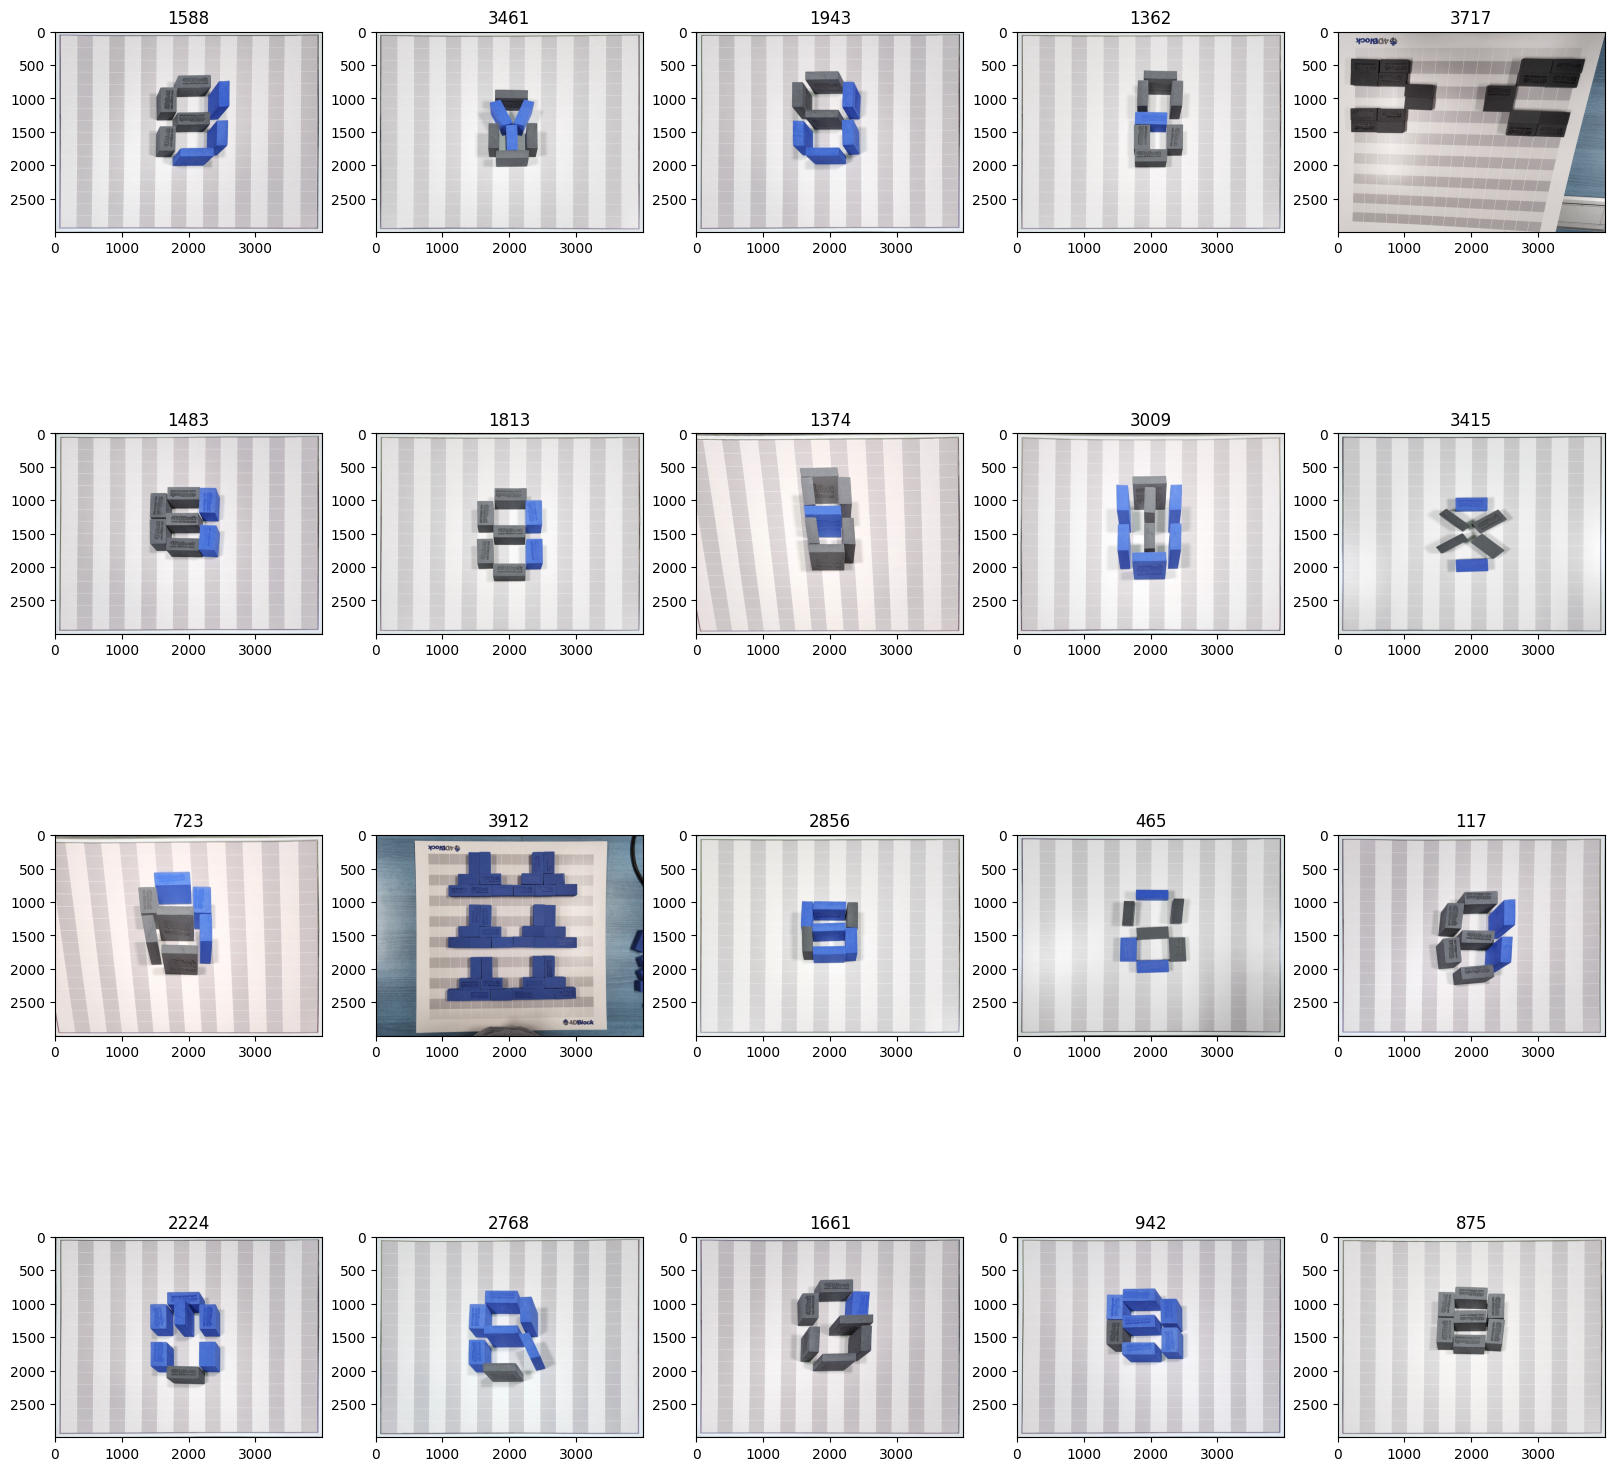

In [103]:
random_idx_sample = df.sample(20).index

fig, ax = plt.subplots(4, 5, figsize=(20, 20))
for i, idx in enumerate(random_idx_sample):
    img = cv2.imread(df['image_path'].iloc[idx])
    warped_img = warp_to_board(img)
    ax[i//5][i%5].imshow(warped_img)
    ax[i//5][i%5].set_title(idx)
plt.show()

Pretty good